# CV Project: MSER

## Alessandro Acquilino (5198425)

The notebook is structured as follows:
- Relevant imports
- Example image reading
- Helper functions
- OpenCV's MSER with duplicate suppression
- Custom MSER implementation with relevant data structures
- Single image comparisons
- Testing
- Visualizations

## Imports

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import time

## Example image

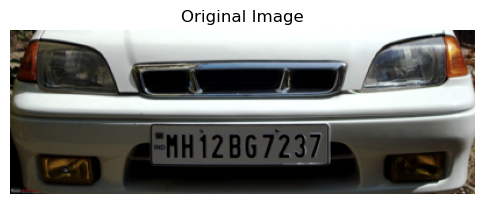

In [34]:
image_path = 'images/Cars12.png'
image = cv2.imread(image_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.show()

## Helper functions

In [3]:
def region_iou(region1, region2, width):
    flat_region1 = np.array([point[0] + point[1] * width for point in region1])
    flat_region2 = np.array([point[0] + point[1] * width for point in region2])
    intersection = np.intersect1d(flat_region1, flat_region2)
    union = np.union1d(flat_region1, flat_region2)
    return len(intersection) / len(union) if len(union) > 0 else 0

def bbox_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)
    intersection_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - intersection_area

    return intersection_area / union_area if union_area > 0 else 0

def prune_duplicate_regions(regions, bboxes, iou_threshold=0.9):
    suppressed_indices = set()
    for i in range(len(regions)):
        if i in suppressed_indices:
            continue
        for j in range(i + 1, len(regions)):
            if j in suppressed_indices:
                continue
            iou = bbox_iou(bboxes[i], bboxes[j])
            if iou > iou_threshold:
                suppressed_indices.add(j)
    return [regions[i] for i in range(len(regions)) if i not in suppressed_indices]

## OpenCV's MSER

In [47]:
mser = cv2.MSER_create()

cv_regions, cv_boxes = mser.detectRegions(gray)

#Suppress similar regions
iou_threshold = 0.9
suppressed_indices = set()
for i in range(len(cv_boxes)):
    if i in suppressed_indices:
        continue
    for j in range(i + 1, len(cv_boxes)):
        if j in suppressed_indices:
            continue
        iou = bbox_iou(cv_boxes[i], cv_boxes[j])
        if iou > iou_threshold:
            suppressed_indices.add(j)

unique_cv_regions = [cv_regions[i] for i in range(len(cv_regions)) if i not in suppressed_indices]

print(f'Detected {len(cv_regions)} regions originally.')
print(f'Detected {len(unique_cv_regions)} regions after suppression.')

def highlight_regions(regions, image):
    """Highlight detected regions on the image."""
    output_image = image.copy()
    for region in regions:
        for point in region:
            output_image[point[1], point[0]] = (0, 255, 0)
    return output_image

def show_region(region, image, ax=None):
    """Visualize a single region on the image."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    output_image = image.copy()
    for point in region:
        output_image[point[1], point[0]] = (0, 255, 0)
    ax.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    # plt.show()

# for region in unique_cv_regions:
#     show_region(region, image)

Detected 211 regions originally.
Detected 86 regions after suppression.


## Custom MSER
Mostly based on the original paper and the wikipedia page, although the paper itself does not provide neither an implementation nor pseudocode.

In [5]:
def bin_sort(gray):
    bins = list(range(256))
    for i in range(256):
        bins[i] = []

    for i in range(gray.shape[0]):
        for j in range(gray.shape[1]):
            bins[gray[i, j]].append((i, j))

    return bins

In [9]:
class RegionUnionFind:
    def __init__(self):
        self.parent = {}
        self.rank = {}
        self.cardinality = {}
        self.roots = set()

    def make_set(self, x):
        if x not in self.parent:
            self.parent[x] = x
            self.rank[x] = 0
            self.cardinality[x] = 1
            self.roots.add(x)

    def find(self, x):
        if x not in self.parent:
            return None

        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, x, y):
        rootX = self.find(x)
        rootY = self.find(y)
        if rootX != rootY and rootX is not None and rootY is not None:
            #union by rank
            if self.rank[rootX] < self.rank[rootY]:
                self.parent[rootX] = rootY
                self.cardinality[rootY] += self.cardinality[rootX]
                self.roots.discard(rootX)
            elif self.rank[rootX] > self.rank[rootY]:
                self.parent[rootY] = rootX
                self.cardinality[rootX] += self.cardinality[rootY]
                self.roots.discard(rootY)
            else:
                self.parent[rootY] = rootX
                self.rank[rootX] += 1
                self.cardinality[rootX] += self.cardinality[rootY]
                self.roots.discard(rootY)
    
    def copy(self):
        new_uf = RegionUnionFind()
        new_uf.parent = self.parent.copy()
        new_uf.rank = self.rank.copy()
        new_uf.cardinality = self.cardinality.copy()
        new_uf.roots = self.roots.copy()
        return new_uf
    
    def get_cardinality(self, x):
        root = self.find(x)
        if root is not None:
            return self.cardinality.get(root, 0)
        return 0
    
    def get_regions(self):
        regions = {}
        for key in self.parent:
            root = self.find(key)
            if root not in regions:
                regions[root] = []
            regions[root].append(key)
        return regions
    
    def get_roots(self):
        return self.roots

In [10]:
def regions_evolution(gray, bins):
    """
    We add all the pixels to the union-find structure based on their intensity.
    Then we 
    """
    uf = RegionUnionFind()
    history = list(range(256))

    for j, bin in enumerate(bins):
        if len(bin) == 0:
            history[j] = uf.copy()
            continue

        for px in bin:
            uf.make_set(px)

            for x, y in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                neighbour = (px[0] + x, px[1] + y)
                if 0 <= neighbour[0] < gray.shape[0] and 0 <= neighbour[1] < gray.shape[1]:
                    uf.union(px, neighbour)

        history[j] = uf.copy()

    return history

In [11]:
def debug_history(history, image):
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255), (255, 0, 255), (128, 128, 128), (255, 165, 0), (75, 0, 130), (238, 130, 238), (255, 20, 147), (0, 191, 255), (34, 139, 34), (255, 105, 180), (70, 130, 180)]

    width = image.shape[1]

    for i in range(len(history)):
        output = np.zeros_like(image)

        for root, region in history[i].get_regions().items():
            color_idx = root[0] * width + root[1]
            for elem in region:
                output[elem] = colors[color_idx % len(colors)]

        plt.figure(figsize=(6, 6))
        plt.imshow(output, cmap='gray')
        plt.title(f'Regions at Intensity {i}')
        plt.axis('off')
        plt.show()

In [12]:
class RegionLineage:
    def __init__(self, original_root, original_i):
        self.original_root = original_root
        self.original_i = original_i
        self.stability = []

    def add_stability(self, i, stability):
        self.stability.append((i, stability))

    def get_last_intensity(self):
        if self.stability:
            return self.stability[-1][0]
        return None

    def print(self):
        print(f"Region {self.original_root} (original intensity {self.original_i}) stability:")
        for i, stability in self.stability:
            print(f"  Intensity {i}: {stability}")

    def get_maximally_stable(self):
        if not self.stability:
            return None
        return min(self.stability, key=lambda x: x[1])

    def print_maximally_stable(self):
        max_stability = self.get_maximally_stable()
        if max_stability is None:
            print(f"Region {self.original_root} (original intensity {self.original_i}) has no stability data.")
            return
        print(f"Maximally stable region {self.original_root} (original intensity {self.original_i}) at intensity {max_stability[0]} with stability {max_stability[1]}")

In [13]:
delta = 5
min_area = 60
max_area = 14400
max_variation = 0.25
# min_diversity = 0.2

def process_regions(history, delta=5, min_area=60, max_area=14400, max_variation=0.25, debug=False):
    """
    Instad of checking the regions at i-delta and i+delta, we check the regions at i+delta and i+2*delta. 
    This removes the need for the search for the ancestor at i-delta.
    We first we check if the lineages are still stable, if not we close them.
    Then we search in the regions if we have to start a new lineage.
    """
    lineages_done = []
    lineages_processing = {}

    for i, snap_prev in enumerate(history):
        next_i = min(i + 2 * delta, len(history) - 1)
        curr_i = min(i + delta, len(history) - 1)
        snap_next = history[next_i]
        snap_curr = history[curr_i]

        lineages_closed = []

        for lineage in lineages_processing.values():
            root_prev = lineage.original_root
            root_next = snap_next.find(root_prev)
            root_curr = snap_curr.find(root_prev)

            card_next = snap_next.get_cardinality(root_next)
            card_prev = snap_prev.get_cardinality(root_prev)
            card_curr = snap_curr.get_cardinality(root_curr)

            if card_curr < min_area or card_curr > max_area:
                lineages_done.append(lineage)
                lineages_closed.append(lineage)
                continue

            stability = (card_next - card_prev) / card_curr

            if debug:
                print(f"Processing lineage for root {lineage.original_root} at intensity {i} with stability {stability}")

            if stability < max_variation:
                if debug:
                    print(f"Adding stability {stability} to lineage for root {lineage.original_root} at intensity {i}")
                lineage.add_stability(i, stability)
            else:
                lineages_done.append(lineage)
                lineages_closed.append(lineage)

        for lineage in lineages_closed:
            del lineages_processing[lineage.original_root]
            if debug:
                print(f"Closed lineage for root {lineage.original_root} with original intensity {lineage.original_i} at intensity {i}")

        for root_prev in snap_prev.get_roots():
            root_next = snap_next.find(root_prev)
            root_curr = snap_curr.find(root_prev)

            card_next = snap_next.get_cardinality(root_next)
            card_prev = snap_prev.get_cardinality(root_prev)
            card_curr = snap_curr.get_cardinality(root_curr)

            if card_curr < min_area or card_curr > max_area:
                continue

            stability = (card_next - card_prev) / card_curr

            if stability < max_variation and card_curr > min_area and card_curr < max_area:
                if root_prev not in lineages_processing:
                    lineages_processing[root_prev] = RegionLineage(root_prev, i)
                
                last_intensity = lineages_processing[root_prev].get_last_intensity()
                if last_intensity == None or last_intensity == i-1:
                    lineages_processing[root_prev].add_stability(i, stability)
        

    return lineages_done

In [14]:
def debug_lineages(lineages):
    for lineage in lineages:
        lineage.print_maximally_stable()

In [15]:
def get_regions(history, lineages_done):
    regions = []
    for lineage in lineages_done:
        max_stable = lineage.get_maximally_stable()
        if max_stable is not None:
            uf = history[max_stable[0]]
            root = uf.find(lineage.original_root)
            regions.append(history[max_stable[0]].get_regions()[root])
    return regions

def show_mser(history, lineages_done, image):
    for lineage in lineages_done:
        max_stable = lineage.get_maximally_stable()
        if max_stable is not None:
            output = image.copy()
            for root, region in history[max_stable[0]].get_regions().items():
                if root == lineage.original_root:
                    for elem in region:
                        output[elem] = (0, 0, 255)
            plt.figure(figsize=(6, 6))
            plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
            plt.title(f'Maximally Stable Region {lineage.original_root} at Intensity {max_stable[0]}')
            plt.axis('off')
            plt.show()

In [16]:
def custom_mser(image, draw=True):
    """
    Full pipeline for MSER detection and lineage processing.
    """
    curr_time = time.time()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    bins = bin_sort(gray)

    print(f"Bin sort took {time.time() - curr_time:.2f} seconds")
    curr_time = time.time()
    history_forward = regions_evolution(gray, bins)
    history_backward = regions_evolution(255-gray, reversed(bins))

    print(f"Regions evolution took {time.time() - curr_time:.2f} seconds")
    curr_time = time.time()

    lineages_forward = process_regions(history_forward, debug=False)
    lineages_backward = process_regions(history_backward, debug=False)

    print(f"Processing regions took {time.time() - curr_time:.2f} seconds")

    print(f"Found {len(lineages_forward)} forward lineages and {len(lineages_backward)} backward lineages.")

    if draw:
        show_mser(history_forward, lineages_forward, image)
        show_mser(history_backward, lineages_backward, image)

    return get_regions(history_forward, lineages_forward) + get_regions(history_backward, lineages_backward), history_forward, history_backward, lineages_forward, lineages_backward
    

In [36]:
custom_regions, history_forward, history_backward, lineages_forward, lineages_backward = custom_mser(image, draw=False)

Bin sort took 0.01 seconds
Regions evolution took 1.07 seconds
Processing regions took 0.06 seconds
Found 36 forward lineages and 18 backward lineages.


## Single image comparisons

In [25]:
for custom_region in custom_regions:
    inverted_custom_region = [[y, x] for (x, y) in custom_region]  # Invert coordinates for display

    corresponding_iou = np.array([], dtype=float)
    for cv_region in unique_cv_regions:
        iou = region_iou(inverted_custom_region, cv_region, image.shape[1])
        corresponding_iou = np.append(corresponding_iou, iou)
        
    max_iou_idx = np.argmax(corresponding_iou)
    max_iou = corresponding_iou[max_iou_idx]
    if max_iou > 0.5:
        print(f"Custom region matches CV region with IoU: {max_iou:.2f} at index {max_iou_idx} with IoU {corresponding_iou[max_iou_idx]:.2f}")
        # plt.figure(figsize=(12, 6))
        # plt.subplot(1, 2, 1)
        # custom_image = highlight_regions([inverted_custom_region], image)
        # plt.imshow(cv2.cvtColor(custom_image, cv2.COLOR_BGR2RGB))
        # plt.axis('off')
        # plt.title(f'Custom Region (IoU: {max_iou:.2f})')
        # plt.subplot(1, 2, 2)
        # cv_region_image = highlight_regions([unique_cv_regions[max_iou_idx]], image)
        # plt.imshow(cv2.cvtColor(cv_region_image, cv2.COLOR_BGR2RGB))
        # plt.axis('off')
        # plt.title(f'CV Region {max_iou_idx} (IoU: {corresponding_iou[max_iou_idx]:.2f})')
        # plt.show()
    else:
        print(f"Custom region does not match any CV region, max IoU: {max_iou:.2f} at index {max_iou_idx}")
        plt.figure(figsize=(6, 6))
        custom_image = highlight_regions([inverted_custom_region], image)
        plt.imshow(cv2.cvtColor(custom_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Custom Region (IoU: {max_iou:.2f})')
        plt.show()

Custom region matches CV region with IoU: 0.94 at index 14 with IoU 0.94
Custom region matches CV region with IoU: 0.79 at index 13 with IoU 0.79
Custom region matches CV region with IoU: 0.90 at index 15 with IoU 0.90
Custom region matches CV region with IoU: 1.00 at index 15 with IoU 1.00
Custom region matches CV region with IoU: 0.99 at index 32 with IoU 0.99
Custom region matches CV region with IoU: 0.98 at index 34 with IoU 0.98
Custom region matches CV region with IoU: 1.00 at index 16 with IoU 1.00
Custom region matches CV region with IoU: 0.94 at index 34 with IoU 0.94
Custom region matches CV region with IoU: 0.93 at index 19 with IoU 0.93
Custom region matches CV region with IoU: 0.83 at index 21 with IoU 0.83
Custom region matches CV region with IoU: 0.97 at index 23 with IoU 0.97
Custom region matches CV region with IoU: 0.81 at index 3 with IoU 0.81
Custom region matches CV region with IoU: 0.97 at index 43 with IoU 0.97
Custom region matches CV region with IoU: 0.97 at in

CV region does not match any custom region, max IoU: 0.00 at index 0


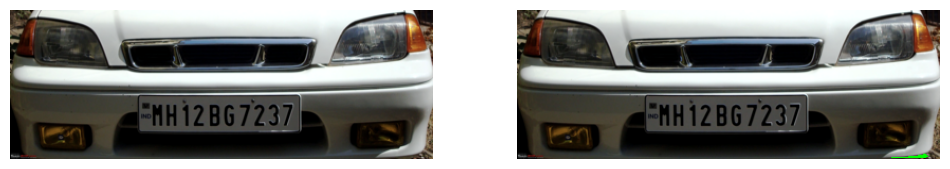

CV region does not match any custom region, max IoU: 0.00 at index 0


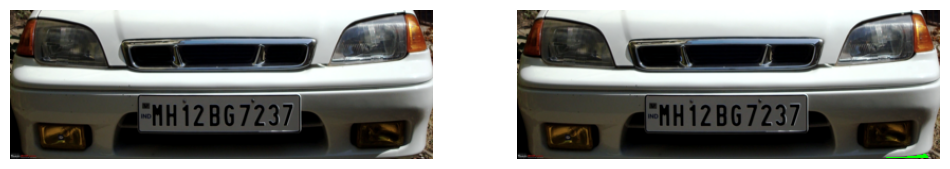

CV region does not match any custom region, max IoU: 0.48 at index 40


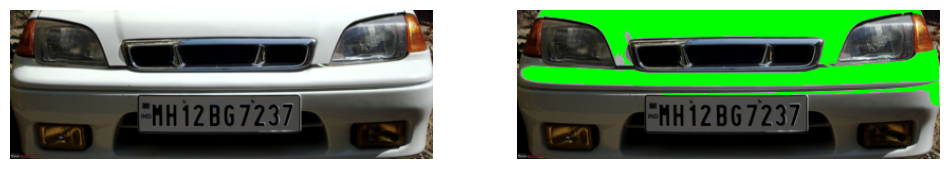

CV region does not match any custom region, max IoU: 0.16 at index 43


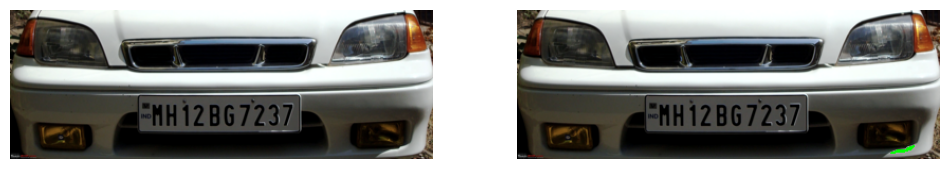

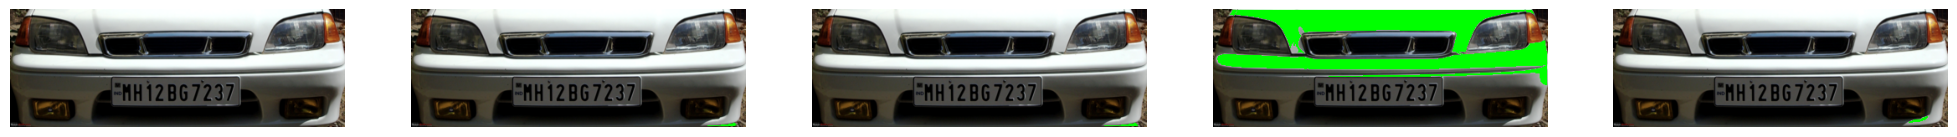

In [50]:
non_matches = []
for cv_region in unique_cv_regions:  # Invert coordinates for display

    corresponding_iou = np.array([], dtype=float)
    for custom_region in custom_regions:
        inverted_custom_region = [[y, x] for (x, y) in custom_region]
        iou = region_iou(inverted_custom_region, cv_region, image.shape[1])
        corresponding_iou = np.append(corresponding_iou, iou)
        
    max_iou_idx = np.argmax(corresponding_iou)
    max_iou = corresponding_iou[max_iou_idx]
    if max_iou > 0.5:
        pass
        # print(f"Custom region matches CV region with IoU: {max_iou:.2f} at index {max_iou_idx} with IoU {corresponding_iou[max_iou_idx]:.2f}")
        # plt.figure(figsize=(12, 6))
        # plt.subplot(1, 2, 1)
        # custom_image = highlight_regions([inverted_custom_region], image)
        # plt.imshow(cv2.cvtColor(custom_image, cv2.COLOR_BGR2RGB))
        # plt.axis('off')
        # plt.title(f'Custom Region (IoU: {max_iou:.2f})')
        # plt.subplot(1, 2, 2)
        # cv_region_image = highlight_regions([unique_cv_regions[max_iou_idx]], image)
        # plt.imshow(cv2.cvtColor(cv_region_image, cv2.COLOR_BGR2RGB))
        # plt.axis('off')
        # plt.title(f'CV Region {max_iou_idx} (IoU: {corresponding_iou[max_iou_idx]:.2f})')
        # plt.show()
    else:
        non_matches.append(cv_region)
        print(f"CV region does not match any custom region, max IoU: {max_iou:.2f} at index {max_iou_idx}")
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        #original image
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        custom_image = highlight_regions([cv_region], image)
        plt.imshow(cv2.cvtColor(custom_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

plt.figure(figsize=(6* len(non_matches)+1, 3))
#original image 
plt.subplot(1, len(non_matches) + 1, 1)

plt.axis('off')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
for i, cv_region in enumerate(non_matches):
    plt.subplot(1, len(non_matches)+ 1, i + 2)
    custom_image = highlight_regions([cv_region], image)
    plt.imshow(cv2.cvtColor(custom_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

## Test suite

In [ ]:
def compare_regions(custom_regions, cv_regions):
    best_ious = np.zeros(len(custom_regions), dtype=float)
    misses = 0
    perfect_matches = 0
    for i, custom_region in enumerate(custom_regions):
        inverted_custom_region = [(x, y) for (y, x) in custom_region]

        comparison_iou = np.array([region_iou(inverted_custom_region, cv_region, image.shape[1]) for cv_region in cv_regions])

        best_cv_match = np.argmax(comparison_iou)
        best_iou = comparison_iou[best_cv_match]

        best_ious[i] = best_iou
        if best_iou < 0.5:
            misses += 1

        if best_iou >= 1.0:
            perfect_matches += 1

    return np.average(best_ious), np.median(best_ious), np.min(best_ious), misses, perfect_matches

def test_suite(images):
    mser = cv2.MSER_create()
    csv_regions = []

    for i, image in enumerate(images):
        print(f"Processing image {i}...")
        custom_regions, history_forward, history_backward, _, _ = custom_mser(image, draw=False)
        cv_regions, cv_boxes = mser.detectRegions(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

        unique_cv_regions = prune_duplicate_regions(cv_regions, cv_boxes, 0.75)

        print(f"Image {i}: Detected {len(custom_regions)} custom regions and {len(unique_cv_regions)} unique CV regions.")

        avg_iou, median_iou, min_iou, misses, perfect = compare_regions(custom_regions, unique_cv_regions)

        reversed_custom_regions = [[(y, x) for (x, y) in region] for region in custom_regions]
        reversed_cv_regions = [[(y, x) for (x, y) in region] for region in unique_cv_regions]

        avg_iou_rev, median_iou_rev, min_iou_rev, misses_rev, perfect_rev = compare_regions(reversed_cv_regions, reversed_custom_regions)

        print(f"Image {i}: Average IoU: {avg_iou:.2f}, Median IoU: {median_iou:.2f}, Min IoU: {min_iou:.2f}")

        csv_regions.append({
            'image_index': i,
            'num_custom_regions': len(custom_regions),
            'num_cv_regions': len(unique_cv_regions),
            'num_original_cv_regions': len(cv_regions),
            'avg_iou': avg_iou,
            'median_iou': median_iou,
            'min_iou': min_iou,
            'misses': misses,
            'perfect_matches': perfect,
            'avg_iou_rev': avg_iou_rev,
            'median_iou_rev': median_iou_rev,
            'min_iou_rev': min_iou_rev,
            'misses_rev': misses_rev,
            'perfect_matches_rev': perfect_rev
        })
    return csv_regions

In [51]:
csv_regions = test_suite(images)
import pandas as pd
df = pd.DataFrame(csv_regions)
df.to_csv('mser_results.csv', index=False)

NameError: name 'test_suite' is not defined

## Visualizations
The tree requires Graphviz to be installed

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.cm as cm
import matplotlib.colors as mcolors
def show_tree(history, lineages, min_area, max_area):
    tree = nx.DiGraph()
    edges = []
    node_weights = {}
    node_colors = {}
    unstable_nodes = set()

    lineage_idx = 1
    for lineage in lineages:
        lineage_idx += 1
        if lineage.get_maximally_stable() is None:
            continue
        original_root = lineage.original_root

        for i, _ in lineage.stability:
            root_at_i = history[i].find(original_root)
            node_colors[f"{i}_{root_at_i[0]}_{root_at_i[1]}"] = lineage_idx

    colors = [
        (.6, .7, .9, .3), (0, 0, 0, 0.1), (1, 0, 0, 1), (0, 1, 0, 1), 
        (0, 0, 1, 1), (1, 1, 0, 1), (0, 1, 1, 1), (1, 0, 1, 1), 
        (0.2, 0.3, 0.6, 1), (1, 0.5, 0, 1), (0.5, 0, 1, 1), (0.5, 1, 0, 1),
        (1, 0, 0.5, 1), (0.3, 0.7, 0.3, 1), (0.7, 0.3, 0.7, 1), 
        (0.3, 0.5, 0.5, 1), (0.8, 0.2, 0.2, 1), (0.2, 0.8, 0.2, 1), 
        (0.2, 0.2, 0.8, 1), (0.8, 0.8, 0.2, 1), (0.2, 0.8, 0.8, 1)
    ]

    for i, h in enumerate(history):
        if i == len(history) - 1:
            continue

        for root in h.get_roots():
            cardinality = h.get_cardinality(root)

            if cardinality < min_area or cardinality > max_area:
                continue

            unstable = False
            if cardinality > max_area:
                unstable = True

            node_id = f"{i}_{root[0]}_{root[1]}"
            next = history[i + 1].find(root)
            if next is None:
                continue

            next_id = f"{i + 1}_{next[0]}_{next[1]}"

            edges.append((node_id, next_id))

            if unstable:
                node_weight = 1
                unstable_nodes.add(node_id)
            elif node_id in node_colors:
                node_weight = node_colors[node_id]
            else:
                node_weight = 0

            node_weights[node_id] = node_weight

    tree.add_edges_from(edges)

    tree_colors = [colors[node_weights.get(node, 0) % len(colors)] for node in tree.nodes()]

    try:
        pos = graphviz_layout(tree, prog="dot")
        plt.figure(figsize=(12, 24))
        nx.draw(
            tree,
            pos,
            with_labels=False,
            node_size=50,
            node_color=tree_colors,
        )
        plt.title("Tree Visualization")
        plt.show()
    except Exception as e:
        print(f"Visualization error: {e}")

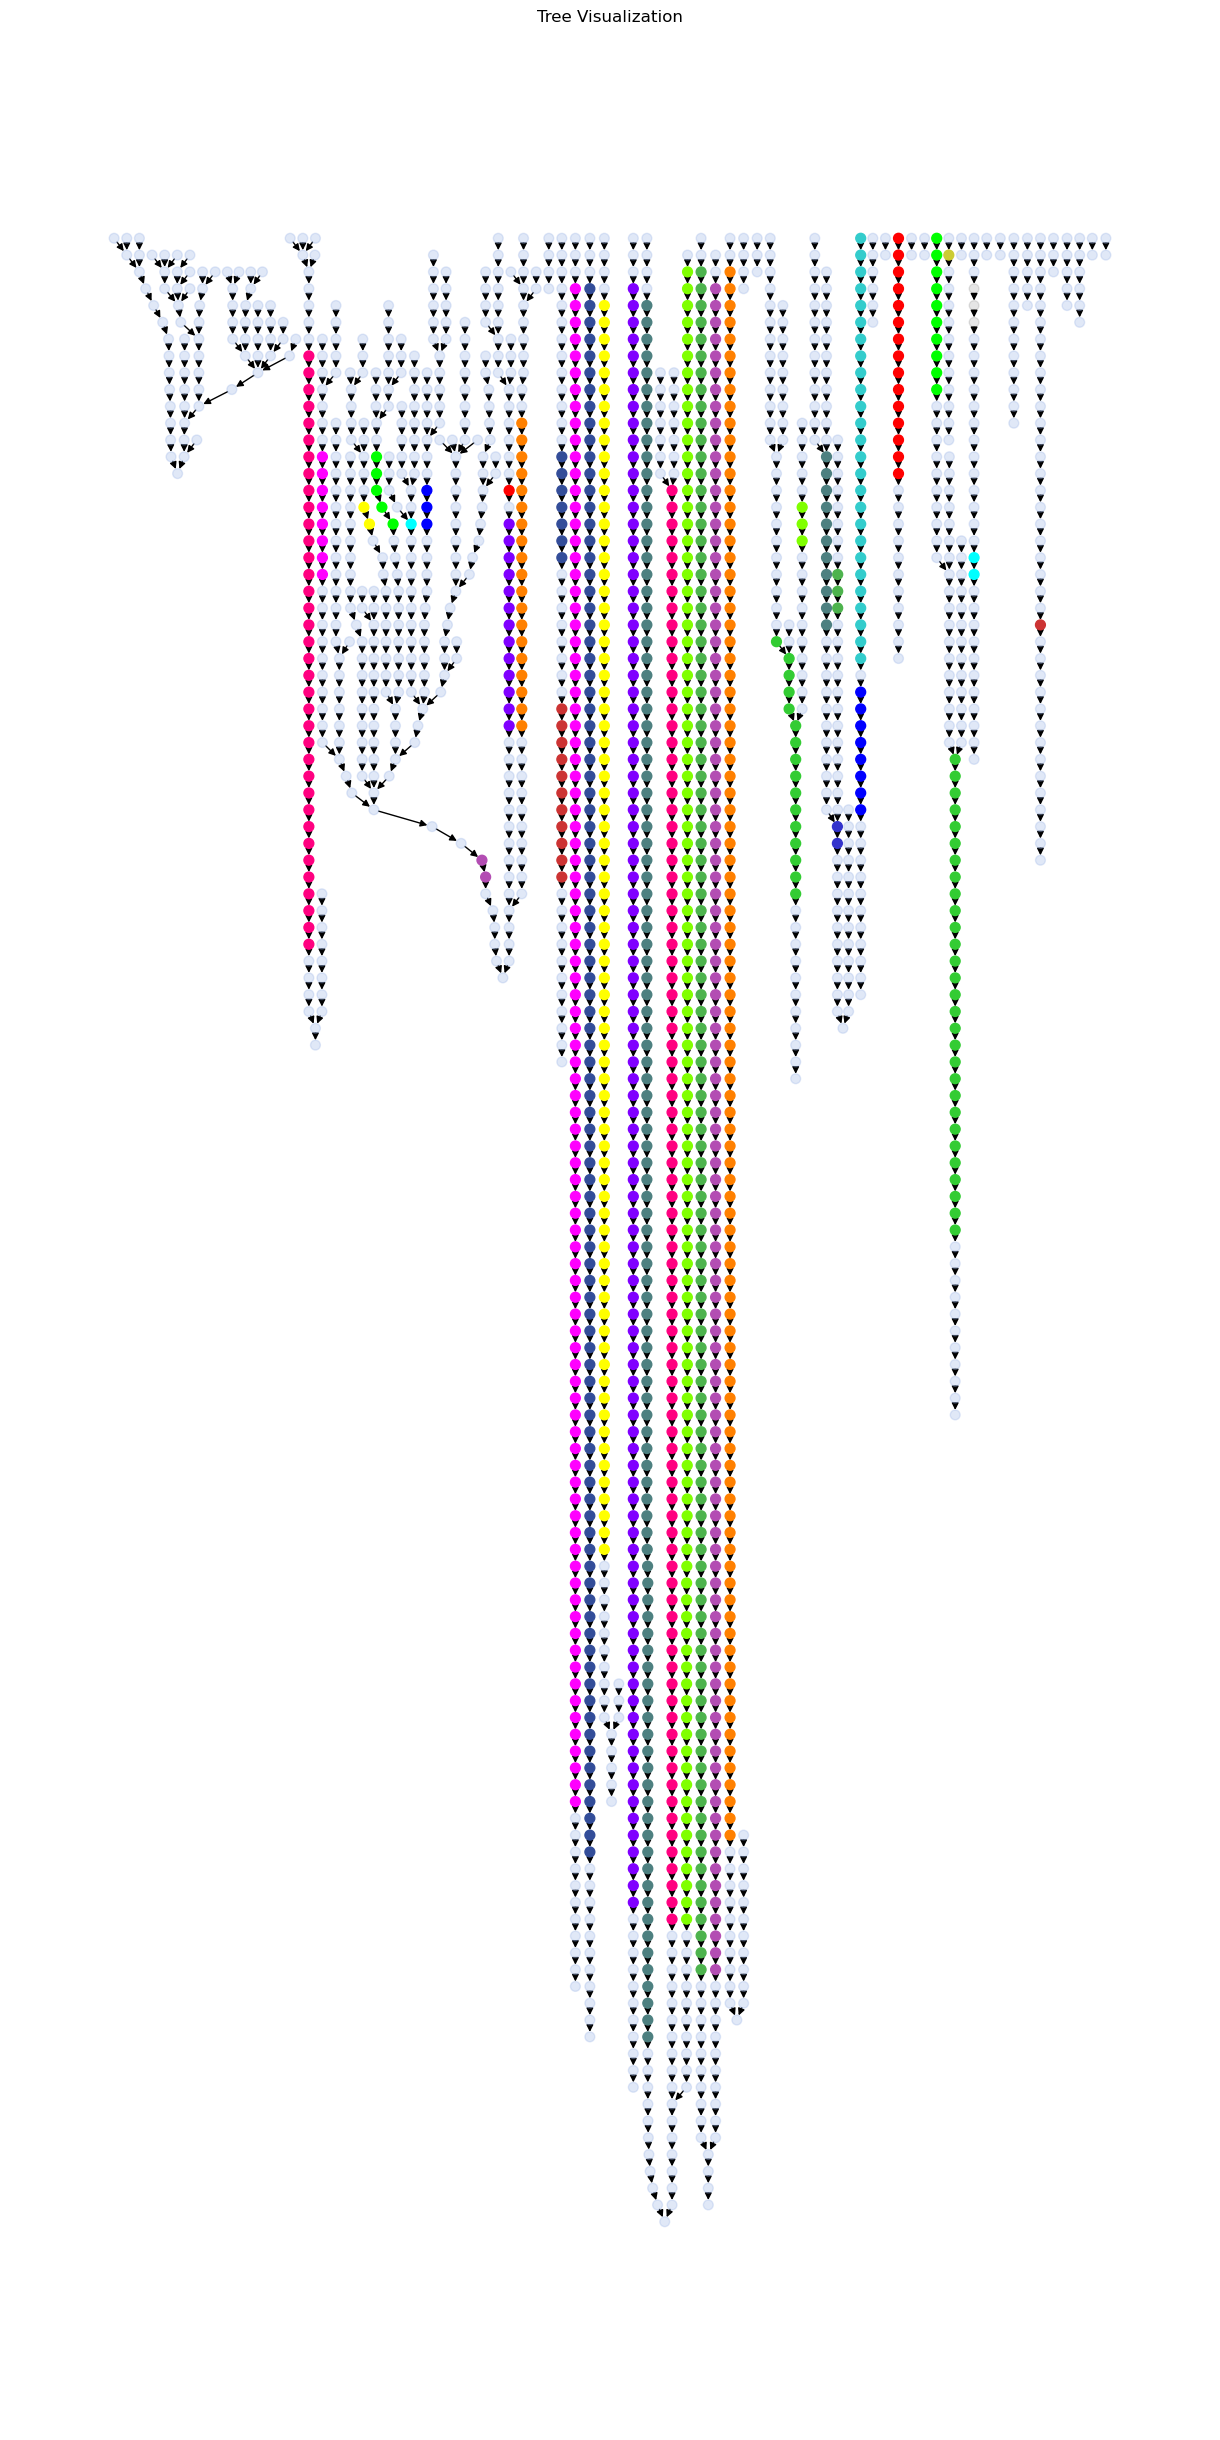

In [33]:
show_tree(history_forward, lineages_forward, min_area, max_area)

In [42]:
compare_regions(custom_regions, cv_regions)

(0.9244936690522663, 0.9651201052977953, 0.12578616352201258)

In [41]:
compare_regions(custom_regions, unique_cv_regions)

(0.8988213804102513, 0.922077922077922, 0.12578616352201258)

In [44]:
file_name = 'images/Cars'
extension = '.png'
images = [cv2.imread(file_name + str(i) + extension) for i in range(0, 100)]

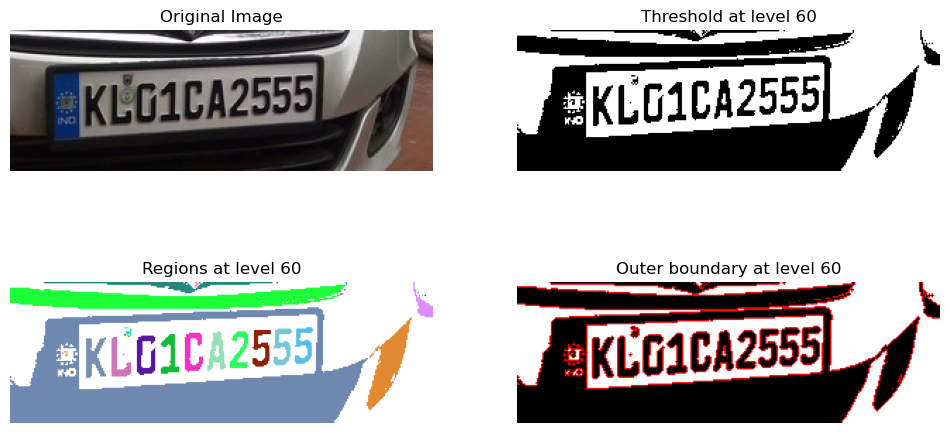

In [ ]:
car0 = cv2.imread('images/Cars0.png')
car0_gray = cv2.cvtColor(car0, cv2.COLOR_BGR2GRAY)
car0_gray = car0_gray[100:200, 200:600]

binary_car0 = cv2.threshold(car0_gray, 60, 255, cv2.THRESH_BINARY)[1]

rgb_car0 = cv2.cvtColor(binary_car0, cv2.COLOR_BGR2RGB)
for i in range(rgb_car0.shape[0]):
    for j in range(rgb_car0.shape[1]):
        for neigh in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            ni, nj = i + neigh[0], j + neigh[1]
            if 0 <= ni < rgb_car0.shape[0] and 0 <= nj < rgb_car0.shape[1]:
                if binary_car0[i, j] == 255 and binary_car0[ni, nj] == 0:
                    rgb_car0[i, j] = [255, 0, 0]

rgb_car1 = cv2.cvtColor(binary_car0, cv2.COLOR_GRAY2RGB)
for i in range(rgb_car1.shape[0]):
    for j in range(rgb_car1.shape[1]):
        if rgb_car1[i, j, 0] == 0:
            queue = [(i, j)]
            color = np.random.randint(1, 255, size=3).tolist()
            while queue:
                x, y = queue.pop(0)
                if 0 <= x < rgb_car1.shape[0] and 0 <= y < rgb_car1.shape[1] and np.array_equal(rgb_car1[x, y], [0, 0, 0]):
                    rgb_car1[x, y] = color
                    queue.extend([(x-1, y), (x+1, y), (x, y-1), (x, y+1)])


plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(car0[100:200, 200:600], cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(binary_car0, cmap='gray')
plt.title('Threshold at level 60')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(rgb_car1, cmap='viridis')
plt.title('Regions at level 60')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(rgb_car0, cmap='viridis')
plt.title('Outer boundary at level 60')
plt.axis('off')
plt.show()

Detected 18 character-like regions.


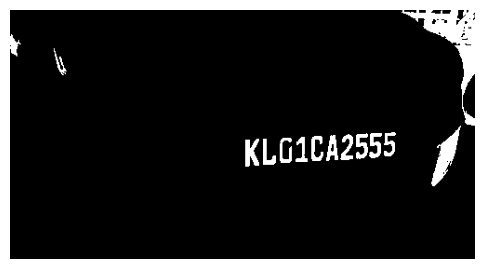

In [66]:
char_regions = []

target_aspect = 2
tolerance = 0.5

char_image = np.zeros_like(image)
for custom_region in custom_regions:
    bbox = cv2.boundingRect(np.array([(x, y) for (y, x) in custom_region]))
    x, y, w, h = bbox
    aspect = h / w
    if abs(aspect - target_aspect) < tolerance:  # Adjust the threshold as needed
        char_regions.append(custom_region)

print(f"Detected {len(char_regions)} character-like regions.")
for char_region in char_regions:
    for point in char_region:
        char_image[point[0], point[1]] = (255, 255, 255)
plt.figure(figsize=(6, 6))
plt.imshow(char_image, cmap='gray')
plt.axis('off')
plt.show()
    

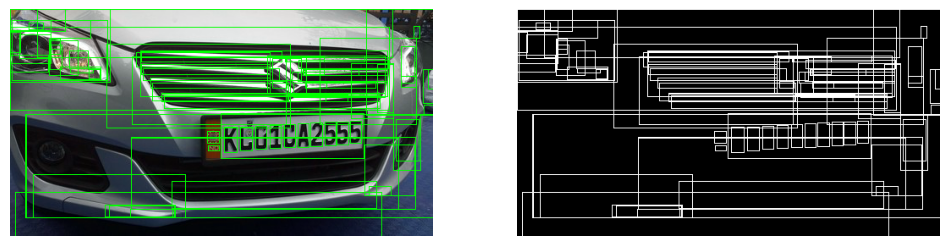

In [ ]:
regions_image = np.copy(image)
region_image_empty = np.zeros_like(image)
for custom_region in custom_regions:
    bbox = cv2.boundingRect(np.array([(x, y) for (y, x) in custom_region]))
    x, y, w, h = bbox
    cv2.rectangle(regions_image, (x, y), (x + w, y + h), (0, 255, 0), 1)  # Draw bounding box
    cv2.rectangle(region_image_empty, (x, y), (x + w, y + h), (255, 255, 255), 1)  # Draw bounding box


    # color = np.random.randint(0, 255, size=3).tolist()  # Random color for each region
    # for point in custom_region:
    #     regions_image[point[0], point[1]] = color
        

    # inverted_custom_region = [(x, y) for (y, x) in custom_region]  # Invert coordinates for display
    # show_region(inverted_custom_region, image)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(regions_image)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(region_image_empty, cmap='gray')
plt.axis('off')
plt.show()